# Analysis of the entire graph

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt, matplotlib as mpl
import numpy as np
import igraph as ig
import networkx as nx
import random
from tqdm import tqdm
import statsmodels.formula.api as smf
import itertools
import pickle

In [2]:
df_edges: pd.DataFrame = pd.read_pickle('../data/generated/graph/actor_graph_full.grouped.pkl')
df_movies: pd.DataFrame = pd.read_pickle('../data/generated/preprocessed/movies.pkl')
df_actors = pd.read_pickle('../data/generated/preprocessed/characters.pkl')

## Graph generation

### Scale estimation and feasibility

Before we dive head first into computing the graph edges, we need to estimate how much space it will take. An upper bound for the number of edges is $\mathcal{O}(\text{number of movies} \times \text{number of actors per movie}^2)$, since each movie links two actors together.

We compute the number of actors per movie.

In [3]:
# Count the number of actors per movie
df_numactors_per_movie = (df_actors
	.groupby('fb_movie_id')
	[['fb_movie_id']]
	.apply('count')
	.rename(columns={'fb_movie_id': 'numactors_per_movie'})
	.sort_values('numactors_per_movie', ascending=False)
	.reset_index()
)
df_numactors_per_movie['movie_name'] = df_movies.set_index('fb_id').loc[df_numactors_per_movie.fb_movie_id].movie_name.values
df_numactors_per_movie

,fb_movie_id,numactors_per_movie,movie_name
0,/m/0cc8620,115,Hemingway & Gellhorn
1,/m/04grkmd,87,Taking Woodstock
2,/m/02725hs,81,Captain Corelli's Mandolin
3,/m/02qr3k8,81,Terror in the Aisles
4,/m/02825cv,72,Walk Hard: The Dewey Cox Story
...,...,...,...
64324,/m/02rxj4c,1,Primo
64325,/m/0bh8lpd,1,The Stranger Who Looks Like Me
64326,/m/0bh8np6,1,On the Wing
64327,/m/0bh8q94,1,Robot Bastard!


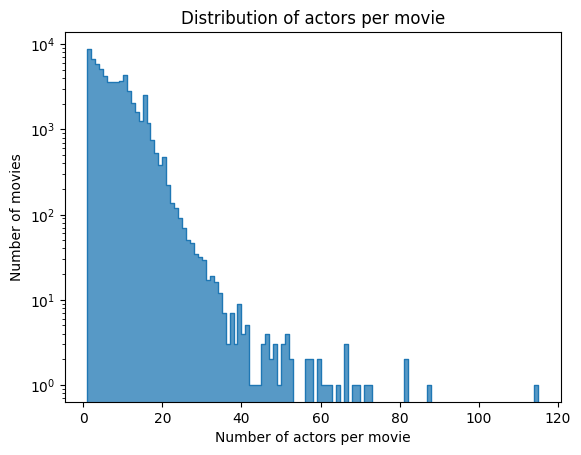

In [4]:
ax = sns.histplot(df_numactors_per_movie, x='numactors_per_movie', binwidth=1, log_scale=(False, True), element='step')
ax.set_xlabel('Number of actors per movie')
ax.set_ylabel('Number of movies')
ax.set_title('Distribution of actors per movie')
plt.show()

In [5]:
print(f'mean={df_numactors_per_movie.numactors_per_movie.mean():.2f}')
print(f'median={df_numactors_per_movie.numactors_per_movie.median():.2f}')

mean=7.01
median=6.00


The distribution of actors per movie is clearly exponential (with a somewhat long tail due to outliers). Let's be pessimistic and pick the largest of the median an the mean, and compute the upper bound.

In [6]:
print(f'num_edges ~ {(float(df_numactors_per_movie.numactors_per_movie.mean())**2 * len(df_actors.fb_movie_id.unique())):.1e}')

num_edges ~ 3.2e+06


### Numerical results

With order $10^6$ edges we will not be doing any full graph visualization, however we can do some analysis on the large graph.

In [7]:
len(df_edges)

2080273

In [8]:
g = ig.Graph.DataFrame(df_edges[['actor1_fbid', 'actor2_fbid', 'movie_count']], directed=False, use_vids=False)
print(g.summary())

IGRAPH UN-- 135061 2080273 -- 
+ attr: name (v), movie_count (e)


Actually performing the computation shows the estimation to be very pessimistic, as we end up with around 200k edges. (and around 224k edges if we keep edges between the two same actors distinct).

The graph contains around 135k actors, spanning movies released between 1888 and 2016.

## Degree distribution

Among other real-life networks, social networks typically exhibit power law distribution of degrees. These types of networks are said to be "scale-free", due to the scale-invariance of the power law. We compute the distribution for the network at hand.

In [9]:
series_degrees = pd.Series(g.degree())
series_degrees.to_pickle('../data/publication/entire_graph/degree.pkl')

In [10]:
pdf = series_degrees.value_counts(normalize=True).sort_index()
ccdf = pdf.sort_index(ascending=False).cumsum()

In [11]:
mask = (pdf.index > 10)
model = smf.ols(formula="logN ~ logk",
	data=dict(logN=np.log10(pdf[mask].values), logk=np.log10(pdf[mask].index)))
res = model.fit()
res.summary()
gamma, gamma_lower, gamma_upper = res.params['logk'], *res.conf_int().loc['logk']

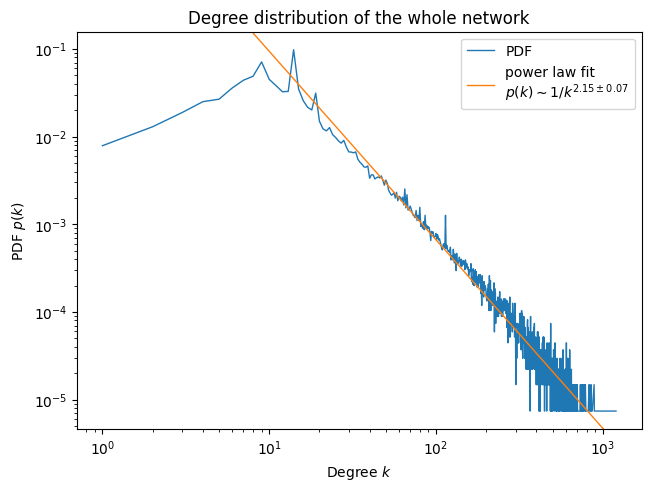

In [12]:
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(pdf.index, pdf.values, linewidth=1, label='PDF')
ax.set_ylabel('PDF $p(k)$')
ax.set_xlabel('Degree $k$')
ax.set_title('Degree distribution of the whole network')
ax.set_xscale('log')
ax.set_yscale('log')
ax.autoscale(False)
ax.plot(pdf.index, 10**res.predict(dict(logk=np.log10(pdf.index))).values,
	linewidth=1, label=f'power law fit\n$p(k) \\sim 1/k^{{{-gamma:.2f} \\pm {gamma_upper-gamma_lower:.2f}}}$')
ax.legend()

plt.show()

This degree distribution clearly follows a power law $p(k) \sim k^{-\gamma}$, and we recover the exponent $\gamma = 1+\mu \approx 2.15 \pm 0.07$.

According to the Molly-Reed condition [1], the entire network is fully connected to a giant component if $\langle k^2 \rangle < 2 \langle k \rangle$. In our case with a power law of $\mu \approx 1.15$, the left hand side integral diverges, and so we expect to find a giant cluster. Although since $\langle k \rangle < \infty$, we expect the giant component has not yet absorbed all clusters ("percolation"), and some smaller localized clusters remain [2].

To put this result into perspective, the Internet has in-degree distribution with $\mu \approx 1$, scientific papers have $\mu \approx 2$, human sexual contacts have $\mu \approx 2.4$ [2]. We are therefore in the presence of a network in which large clusters play an important role.

[1] molloy_1995

[2] mezard_2015

## Clusters and diameter

We compute the connected components of the graph (clusters), as well as their diameter. As the true diameter computation scales as $\mathcal O(\text{number of nodes})^3$, we resort to using an approximative algorithm.

In [50]:
# we use networkx here, because igraph does not have the diameter approximation
# and exact diameter is very slow to compute (O(V³))
g = nx.from_pandas_edgelist(df_edges, source='actor1_fbid', target='actor2_fbid')
df_clusters = pd.DataFrame(
	[
		(len(c), nx.approximation.diameter(g.subgraph(c), seed=1))
		for c in nx.connected_components(g)
	],
	columns=['size', 'approx_diameter']
)
df_clusters.to_pickle('../data/publication/entire_graph/clusters.pkl')

In [149]:
print(f'number of clusters = {len(df_clusters)}')

number of clusters = 1272


In [158]:
print(f'the giant cluster encompasses approx {df_clusters["size"].max() / g.number_of_nodes():.0%} of the total nodes')

the giant cluster encompasses approx 94% of the total nodes


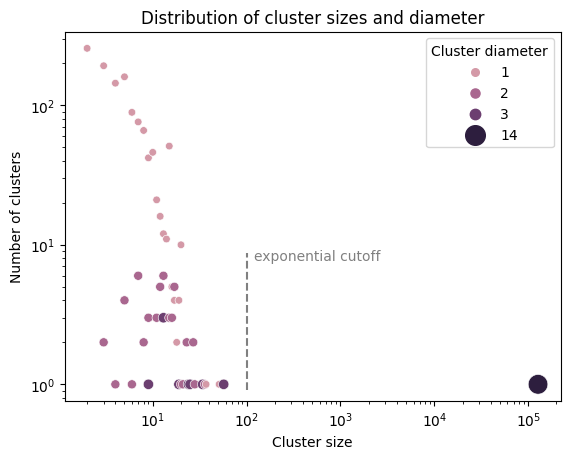

In [207]:
histd = df_clusters.groupby('size')[['approx_diameter']].value_counts().sort_index().reset_index(name='count')
ax = sns.scatterplot(data=histd, x='size', y='count', hue='approx_diameter', size='approx_diameter', legend='full', hue_norm=(0, 4), sizes=(30, 200))
sns.move_legend(ax, loc='upper right', title='Cluster diameter')
ax.axvline(100, 0.03, 0.4, linestyle='--', color='gray')
ax.annotate('exponential cutoff', xy=(120, 0.38), xycoords=('data', 'axes fraction'), color='gray')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Cluster size')
ax.set_ylabel('Number of clusters')
ax.set_title('Distribution of cluster sizes and diameter')
plt.show()

As expected, we indeed have a giant cluster containing $\sim 10^5$ actors, accounting for about $94\%$ of the total number of actors in the graph.

We also remark that even though the cluster size spans orders of magnitude, the cluster diameter spans between 1 and 14. The small clusters contain up to $10^2$ actors have diameter at most 3, and their size seem to roughly follow a power law with exponential cutoff [2]. Albeit its exponentially large size, the giant component has a diameter of 14, which is in-line with the small-world characteristic of scale-free networks : the diameter of the network scales only logarithmically with its size, i.e. $d \sim \log N$ [3].

[3] barabasi_2000